In [104]:
# init
import math
import os
import numpy as np
from numpy import fft
import cv2
import matplotlib.pyplot as plt
import method_reuse
import sys
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [105]:
# https://blog.csdn.net/wangrongrongwq/article/details/119697504
# sys.path.append("..")
# from HW3 import proj1
# from HW3 import proj2
#设置低通滤波器
def low_pass_filter(img, dftshift):
    (rows, cols) = img.shape                 # 解包
    crow, ccol = int(rows/2), int(cols/2)    # center
    mask = np.zeros((rows, cols, 2), np.uint8)
    mask[crow-50:crow+50, ccol-50:ccol+50]=1 # 将中心部分置为1 （也就是低频部分）
    # 将掩膜图像和频谱图像乘积并返回
    return dftshift * mask
#傅里叶变换
def fourier_transform(img):
    dft = cv2.dft(np.float32(img), flags = cv2.DFT_COMPLEX_OUTPUT)
    dftshift = np.fft.fftshift(dft)
    res1 = 20*np.log(cv2.magnitude(dftshift[:,:,0], dftshift[:,:,1]))
    return dftshift, res1
#傅里叶逆变换
def inverse_fourier_transform(dftshift):
    ishift = np.fft.ifftshift(dftshift)
    iimg = cv2.idft(ishift)
    res2 = cv2.magnitude(iimg[:,:,0], iimg[:,:,1])
    return iimg, res2

In [106]:
# 仿真运动模糊
def motion_process(image_size, motion_angle):
    PSF = np.zeros(image_size)
    center_position = (image_size[0] - 1) / 2
    slope_tan = math.tan(motion_angle * math.pi / 180)
    slope_cot = 1 / slope_tan
    if slope_tan <= 1:
        for i in range(15):
            offset = round(i * slope_tan)  # ((center_position-i)*slope_tan)
            PSF[int(center_position + offset), int(center_position - offset)] = 1
        return PSF / PSF.sum()  # 对点扩散函数进行归一化亮度
    else:
        for i in range(15):
            offset = round(i * slope_cot)
            PSF[int(center_position - offset), int(center_position + offset)] = 1
        return PSF / PSF.sum()

In [107]:
# 对图片进行运动模糊
def make_blurred(input, PSF, eps):
    input_fft = fft.fft2(input)  # 进行二维数组的傅里叶变换
    PSF_fft = fft.fft2(PSF) + eps
    blurred = fft.ifft2(input_fft * PSF_fft)
    blurred = np.abs(fft.fftshift(blurred))
    return blurred

In [108]:
# 逆滤波
def inverse(input, PSF, eps):
    input_fft = fft.fft2(input)
    PSF_fft = fft.fft2(PSF) + eps  # 噪声功率，这是已知的，考虑epsilon
    result = fft.ifft2(input_fft / PSF_fft)  # 计算F(u,v)的傅里叶反变换
    result = np.abs(fft.fftshift(result))
    return result

In [109]:
# 维纳滤波，K=0.01
def wiener(input, PSF, eps, K=0.01):
    input_fft = fft.fft2(input)
    PSF_fft = fft.fft2(PSF) + eps
    PSF_fft_1 = np.conj(PSF_fft) / (np.abs(PSF_fft) ** 2 + K)
    result = fft.ifft2(input_fft * PSF_fft_1)
    result = np.abs(fft.fftshift(result))
    return result

In [114]:
def put(path):
    img = cv2.imread(path, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_h = img.shape[0]
    img_w = img.shape[1]
    # 进行运动模糊处理
    PSF = motion_process((img_h, img_w), 60)

    blurred = np.abs(make_blurred(img, PSF, 1e-3))
    # 逆滤波
    res1 = inverse(blurred, PSF, 1e-3)
    # 维纳滤波
    res2 = wiener(blurred, PSF, 1e-3)
    
    # 添加噪声,standard_normal产生随机的函数
    blurred_noisy = blurred + 0.1 * blurred.std() * np.random.standard_normal(blurred.shape)
    # 对添加噪声的图像进行逆滤波
    res3 = inverse(blurred_noisy, PSF, 0.2 + 1e-3)
    # 对添加噪声的图像进行维纳滤波
    res4 = wiener(blurred_noisy, PSF, 0.2 + 1e-3)
    
    # 给图像添加高斯噪声
    gaussian_img = Gaussnoise_func(img)
    # 给高斯图像添加滤波
    gaussian_filter_img = gaussian(gaussian_img)
    # 用低通滤波器来过滤噪声
    (dftshift, res1) = fourier_transform(gaussian_img)
    f1 = low_pass_filter(img, dftshift)
    (ishift, res2) = inverse_fourier_transform(f1)
    
    # plt.imshow(img, plt.cm.gray), plt.title('原图'),plt.savefig('1.new.jpg')
    # plt.imshow(gaussian_img, plt.cm.gray), plt.title("1"),plt.savefig('2.new.jpg')
    # plt.imshow(gaussian_filter_img, plt.cm.gray), plt.title("2"),plt.savefig('3.new.jpg')
    # plt.imshow(res2, plt.cm.gray), plt.title("3"),plt.savefig('4.new.jpg')

    plt.subplot(3, 4, 1), plt.axis('off'), plt.imshow(img, plt.cm.gray), plt.title(' 原图')
    plt.subplot(3, 4, 2), plt.axis('off'), plt.imshow(blurred, plt.cm.gray), plt.title('运动模糊')
    plt.subplot(3, 4, 3), plt.axis('off'), plt.imshow(res1, plt.cm.gray), plt.title(' 逆滤波')
    plt.subplot(3, 4, 4), plt.axis('off'), plt.imshow(res2, plt.cm.gray), plt.title(' 维纳滤波(k=0.01)')
    plt.subplot(3, 4, 5), plt.axis('off'), plt.imshow(img, plt.cm.gray), plt.title(' 原图')
    plt.subplot(3, 4, 6), plt.axis('off'), plt.imshow(blurred_noisy, plt.cm.gray), plt.title('有噪声且运动模糊')
    plt.subplot(3, 4, 7), plt.axis('off'), plt.imshow(res3, plt.cm.gray), plt.title(' 逆滤波')
    plt.subplot(3, 4, 8), plt.axis('off'), plt.imshow(res4, plt.cm.gray), plt.title(' 维纳滤波(k=0.01)')
    plt.subplot(3, 4, 9), plt.axis('off'), plt.imshow(img, plt.cm.gray), plt.title("原图")
    plt.subplot(3, 4, 10), plt.axis('off'), plt.imshow(gaussian_img, plt.cm.gray), plt.title("高斯噪声处理")
    plt.subplot(3, 4, 11), plt.axis('off'), plt.imshow(gaussian_filter_img, plt.cm.gray), plt.title("高斯滤波处理")
    plt.subplot(3, 4, 12), plt.axis('off'), plt.imshow(res2, plt.cm.gray), plt.title("低通滤波器处理")
    

    # plt.savefig('3.new.jpg')
    plt.show()

In [115]:
def Gaussnoise_func(image, mean=0, var=0.005):
    ''' 
    添加高斯噪声
    mean : 均值 
    var : 方差
    '''
    image = np.array(image/255, dtype=float)                    #将像素值归一
    noise = np.random.normal(mean, var ** 0.5, image.shape)     #产生高斯噪声
    out = image + noise                                         #直接将归一化的图片与噪声相加

    '''
    将值限制在(-1/0,1)间，然后乘255恢复
    '''
    if out.min() < 0:
        low_clip = -1.
    else:
        low_clip = 0.

    out = np.clip(out, low_clip, 1.0)
    out = np.uint8(out*255)
    return out

# ————————————————
# 版权声明：本文为CSDN博主「心_kokoro」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
# 原文链接：https://blog.csdn.net/Mikumiku339/article/details/109534376

In [116]:
def gaussian(img):
    return cv2.GaussianBlur(img, ksize=(3,3), sigmaX=0, sigmaY=0)

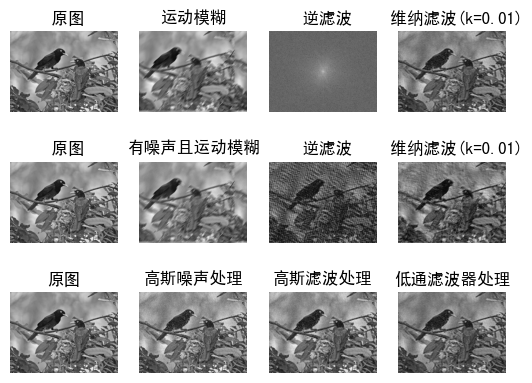

In [117]:
if __name__ == "__main__":
    put("OIP-C.jpg")